# Прогнозирование температуры звезды

**Заказчик: обсерватория «Небо на ладони».**

**Задача: разработать нейронную сеть, предсказывающую абсолютную температуру на поверхности звезды.**

**Получены данные 240 звезд.**

**Имеющиеся характеристики:**
* Относительная светимость L/Lo — светимость звезды относительно Солнца.
* Относительный радиус R/Ro — радиус звезды относительно радиуса Солнца.
* Абсолютная звёздная величина Mv — физическая величина, характеризующая блеск звезды.
* Звёздный цвет (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа.
* Тип звезды.


*Тип звезды и номер, соответствующий типу: Коричневый карлик - 0, Красный карлик	- 1, Белый карлик -	2, Звёзды главной последовательности - 3, Сверхгигант - 4, Гипергигант - 5.*

* Абсолютная температура T(K) — температура на поверхности звезды в Кельвинах.

**Справочная информация:**
* Светимость Солнца (англ. Average Luminosity of Sun) Lo = 3.828 * 10^26, Вт
* Радиус Солнца (англ. Average Radius of Sun) Ro = 6.9551 * 10^8, м

In [2]:
!pip install -U skorch >> None

## Загрузка данных

In [2]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import itertools
from skorch.callbacks import EpochScoring, EarlyStopping
from skorch import NeuralNetRegressor
from sklearn.model_selection import RandomizedSearchCV
from math import ceil
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import sys
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import make_scorer
TEST_SIZE = 0.2

In [3]:
df = pd.read_csv('/datasets/6_class.csv')

In [4]:
df.head()

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,0,3068,0.002400,0.1700,16.12,0,Red
1,1,3042,0.000500,0.1542,16.60,0,Red
2,2,2600,0.000300,0.1020,18.70,0,Red
3,3,2800,0.000200,0.1600,16.65,0,Red
4,4,1939,0.000138,0.1030,20.06,0,Red


## Предобработка и анализ данных

### Общая информация о данных

In [5]:
def info(data):
    print('Общая информация о данных')
    data.info()
    print()
    print('Количество пропусков в каждом столбце')
    print(data.isnull().sum())
    print()
    print('Количество дубликатов')
    print(data.duplicated().sum())
    return 
info(df)

Общая информация о данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              240 non-null    int64  
 1   Temperature (K)         240 non-null    int64  
 2   Luminosity(L/Lo)        240 non-null    float64
 3   Radius(R/Ro)            240 non-null    float64
 4   Absolute magnitude(Mv)  240 non-null    float64
 5   Star type               240 non-null    int64  
 6   Star color              240 non-null    object 
dtypes: float64(3), int64(3), object(1)
memory usage: 13.2+ KB

Количество пропусков в каждом столбце
Unnamed: 0                0
Temperature (K)           0
Luminosity(L/Lo)          0
Radius(R/Ro)              0
Absolute magnitude(Mv)    0
Star type                 0
Star color                0
dtype: int64

Количество дубликатов
0


Как и было заявлено, в наличии характеристики о 240 звездах. Пропусков и дубликатов нет. В столбцах Temperature (K), Luminosity(L/Lo), Radius(R/Ro)	находятся количественные переменные, а в Star type и Star color - категориальные. Столбец Unnamed: 0 не несет смысловой нагрузки, дублирует индексы, поэтому можем его удалить.

In [6]:
df = df.drop('Unnamed: 0', axis=1)
df.head()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,3068,0.002400,0.1700,16.12,0,Red
1,3042,0.000500,0.1542,16.60,0,Red
2,2600,0.000300,0.1020,18.70,0,Red
3,2800,0.000200,0.1600,16.65,0,Red
4,1939,0.000138,0.1030,20.06,0,Red


In [7]:
display(df.describe())

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type
count,240.000000,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,40000.000000,849420.000000,1948.500000,20.060000,5.000000


Удалять выбросы не будем, ввиду малого количества строк в датасете. 

### Категориальные признаки

In [8]:
# изменим названия столбцов 
df.columns = ['temperature', 'luminosity', 'radius', 'absolute_magnitude', 'star_type', 'star_color']

In [9]:
# посмотрим количество уникальных значений в столбце Star color
df['star_color'].value_counts()

Red                   112
Blue                   55
Blue-white             26
Blue White             10
yellow-white            8
White                   7
Blue white              3
Yellowish White         3
white                   3
Whitish                 2
Orange                  2
yellowish               2
Blue                    1
Blue white              1
Pale yellow orange      1
Blue-White              1
Orange-Red              1
White-Yellow            1
Yellowish               1
Name: star_color, dtype: int64

В столбце Star color одинаковые цвета написаны в разном регистре и суммируются как разные. Исправим это.

In [10]:
df['star_color'] = df['star_color'].str.lower()

In [11]:
# посмотрим количество уникальных значений в столбце Star color после их перевода в нижний регистр
df['star_color'].value_counts()

red                   112
blue                   55
blue-white             27
blue white             13
white                  10
yellow-white            8
yellowish white         3
yellowish               3
orange                  2
whitish                 2
pale yellow orange      1
white-yellow            1
orange-red              1
blue                    1
blue white              1
Name: star_color, dtype: int64

Видим, что некоторые значения одинаковы по своей сути, но записаны по-разному. К примеру, blue-white и blue white. Исправим это.

In [12]:
df['star_color'] = df['star_color'].str.replace('blue white', 'blue-white')
df['star_color'] = df['star_color'].str.replace('white-yellow', 'yellow-white')
df['star_color'] = df['star_color'].str.replace('yellowish white', 'yellowish-white')
df['star_color'] = df['star_color'].str.replace('pale yellow orange', 'pale-yellow-orange')

In [13]:
# посмотрим количество уникальных значений в столбце Star color после их перевода в нижний регистр
df['star_color'].value_counts()

red                   112
blue                   55
blue-white             40
white                  10
yellow-white            9
yellowish-white         3
yellowish               3
orange                  2
whitish                 2
blue-white              1
orange-red              1
blue                    1
pale-yellow-orange      1
Name: star_color, dtype: int64

In [14]:
# удаляем пробелы, которые мешают одинаковым значениям суммироваться
df['star_color'] = df['star_color'].replace(r'\s+','',regex=True)

In [15]:
df['star_color'].value_counts()

red                   112
blue                   56
blue-white             41
white                  10
yellow-white            9
yellowish-white         3
yellowish               3
orange                  2
whitish                 2
orange-red              1
pale-yellow-orange      1
Name: star_color, dtype: int64

Удаляем из датасета строки, где количество звезд меньше 3, в зависимости от цвета - 'Star color', для лушего обучения модели:

In [16]:
df = df.groupby('star_color').filter(lambda x : len(x)>3)

In [17]:
df['star_color'].value_counts()

red             112
blue             56
blue-white       41
white            10
yellow-white      9
Name: star_color, dtype: int64

In [18]:
# посмотрим количество уникальных значений в столбце Star type
df['star_type'].value_counts()

0    40
1    40
4    40
5    38
2    36
3    34
Name: star_type, dtype: int64

### Количественные признаки

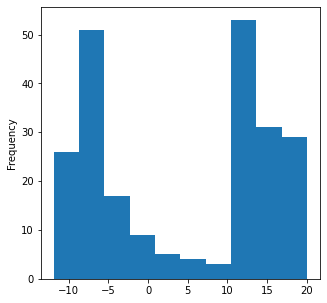

In [19]:
df['absolute_magnitude'].plot(kind="hist", figsize=(5,5)); 

Абсолютная звездная величина (М) описывает собственную светимость, излучаемую объектом, и определяется как равная видимой звездной величине, которую имел бы объект, если бы он находился на определенном расстоянии от Земли, 10 парсеков для звезд. Звёздная величина самых ярких объектов отрицательна. По графику зависимости абсолютной звездной величины от частоты видим, что наибольшее количество "светил" имеют величину от -5 до -10 и от 11 до 20.

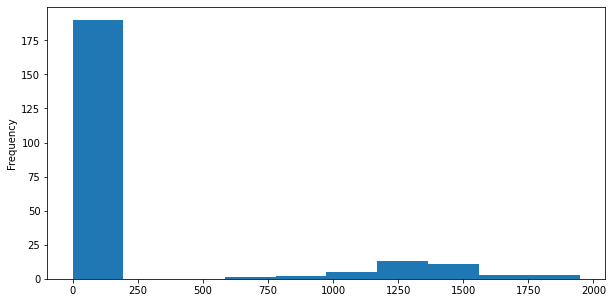

In [20]:
df['radius'].plot(kind="hist", figsize=(10,5)); 

Подавляющее большинство звезд имеют радиус до 200 * 10^8, м.

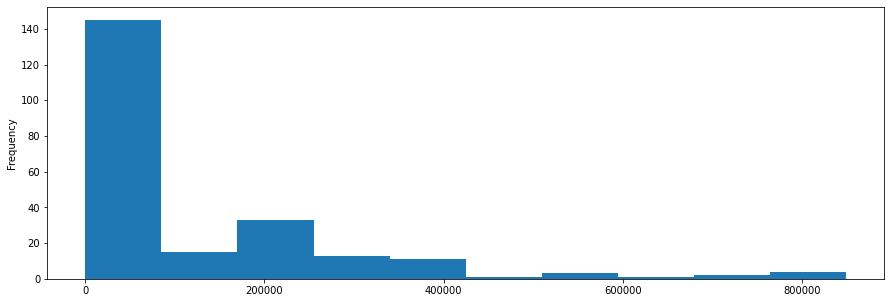

In [21]:
df['luminosity'].plot(kind="hist", figsize=(15,5)); 

Подавляющее большинство звезд имеют относительную светимость до 50 000 * 10^8 Вт. 

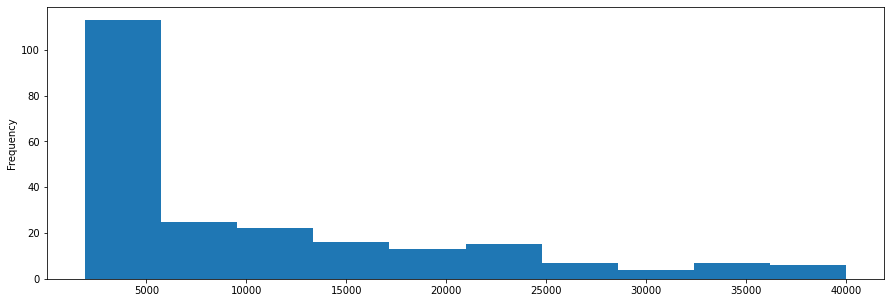

In [22]:
df['temperature'].plot(kind="hist", figsize=(15,5)); 

Большинство звезд имеют температуру до 6000 К.

### Корреляция признаков между собой

In [32]:
display(df.corr()) 

,temperature,luminosity,radius,absolute_magnitude,star_type
temperature,1.000000,0.419711,0.074845,-0.433396,0.430042
luminosity,0.419711,1.000000,0.494683,-0.692119,0.678838
radius,0.074845,0.494683,1.000000,-0.603236,0.659026
absolute_magnitude,-0.433396,-0.692119,-0.603236,1.000000,-0.958825
star_type,0.430042,0.678838,0.659026,-0.958825,1.000000


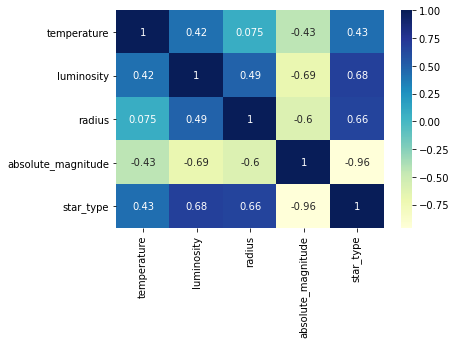

In [33]:
df_plot = sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)  
plt.show()

* **Наблюдается наибольшая отрицательная корреляция между абсолютной звездной величиной и типом звезды, коэф= -0.96.**
* Температура не коррелирует ни с одной из представленных характеристик.
* Относительная светимость коррелирует с типом звезды, коэф.= 0.68 и слабая корреляция с радиусом, коэф.= 0.53 и обратная корреляция с абсолютной звездной величиной,коэф.= -0.69.
* Радиус коррелирует с типом звезды, коэф.= 0.66, и с абсолютной звездной величиной,коэф.= -0.61.
* Абсолютная звездная величина имеет обратную корреляцию со светимостью, коэф.= -0.69, радиусом коэф.= -0.61,
* Тип звезды коррелрует со светимостью коэф.= 0.68, радиусом коэф.= 0.66.

Изобразим на графике корреляцию между абсолютной звездной величиной и типом звезды:

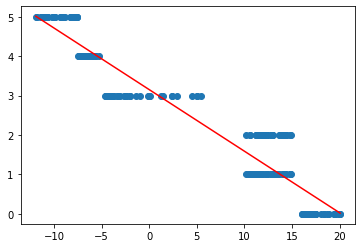

In [34]:
plt.scatter(df['absolute_magnitude'], df['star_type']) 
plt.plot(np.unique(df['absolute_magnitude']), np.poly1d(np.polyfit(df['absolute_magnitude'], df['star_type'], 1))
         (np.unique(df['absolute_magnitude'])), color='red')

### Подготовка данных к построению модели

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 228 entries, 0 to 239
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   temperature         228 non-null    int64  
 1   luminosity          228 non-null    float64
 2   radius              228 non-null    float64
 3   absolute_magnitude  228 non-null    float64
 4   star_type           228 non-null    int64  
 5   star_color          228 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 12.5+ KB


In [36]:
# так как признаки в столбце Star type категориальные, изменим тип данных на object
df['star_type'] = df['star_type'].astype(object)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 228 entries, 0 to 239
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   temperature         228 non-null    int64  
 1   luminosity          228 non-null    float64
 2   radius              228 non-null    float64
 3   absolute_magnitude  228 non-null    float64
 4   star_type           228 non-null    object 
 5   star_color          228 non-null    object 
dtypes: float64(3), int64(1), object(2)
memory usage: 12.5+ KB


In [37]:
features_train, features_test, target_train, target_test = train_test_split(df.drop('temperature', axis=1), df['temperature'], test_size=TEST_SIZE, random_state=123)

Закодируем признаки:

In [38]:
# соберем в список категориальные данные
cat_col = [
        i for i in features_train.dtypes.index if features_train.dtypes[i] == 'object'
    ]

In [39]:
cat_col

['star_type', 'star_color']

In [40]:
# соберем в список количественные данные
num_col = [
        i for i in features_train.dtypes.index if features_train.dtypes[i] != 'object'
    ]

In [41]:
num_col

['luminosity', 'radius', 'absolute_magnitude']

In [42]:
# Инициализация 
enc = OneHotEncoder(handle_unknown='ignore')

cat_features_train = features_train[cat_col]
cat_features_test = features_test[cat_col]

enc.fit(cat_features_train)

OneHotEncoder(handle_unknown='ignore')

In [43]:
cat_features_train = pd.DataFrame(
    enc.transform(cat_features_train).toarray(), 
    columns=enc.get_feature_names(cat_col)
                                  )

cat_features_train.head(3)

,star_type_0,star_type_1,star_type_2,star_type_3,star_type_4,star_type_5,star_color_blue,star_color_blue-white,star_color_red,star_color_white,star_color_yellow-white
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [44]:
cat_features_test = pd.DataFrame(
    enc.transform(cat_features_test).toarray(), 
    columns=enc.get_feature_names(cat_col)
                                 )

cat_features_test.head(3)

,star_type_0,star_type_1,star_type_2,star_type_3,star_type_4,star_type_5,star_color_blue,star_color_blue-white,star_color_red,star_color_white,star_color_yellow-white
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [45]:
# Инициализация стандартизатора
scaler = StandardScaler()

# Передача датасета и преобразование
scaler.fit(features_train[num_col])
features_train[num_col] = scaler.transform(features_train[num_col])
features_test[num_col] = scaler.transform(features_test[num_col])

In [46]:
# удаляем категориальные данные из датафреймов для последующего объединения с кодированными признаками
features_train = features_train.drop(cat_col, axis=1)
features_test = features_test.drop(cat_col, axis=1)
features_train.head()

,luminosity,radius,absolute_magnitude
59,0.426203,2.386272,-1.411382
10,-0.628782,-0.481951,0.636340
106,1.335113,-0.365978,-0.897827
101,3.769693,-0.456915,-0.934974
30,0.474894,-0.463225,-0.792887


In [47]:
# сбросим индексы для последующего корректного объединения данных и удалим ненужный столбец "index"
features_train = features_train.reset_index()
features_train = features_train.drop(columns=['index'], axis=1)
features_train.head()

,luminosity,radius,absolute_magnitude
0,0.426203,2.386272,-1.411382
1,-0.628782,-0.481951,0.636340
2,1.335113,-0.365978,-0.897827
3,3.769693,-0.456915,-0.934974
4,0.474894,-0.463225,-0.792887


In [48]:
# сбросим индексы для последующего корректного объединения данных и удалим ненужный столбец "index"
features_test = features_test.reset_index()
features_test = features_test.drop(columns=['index'], axis=1)
features_test.head()

,luminosity,radius,absolute_magnitude
0,0.117823,2.152432,-1.116065
1,-0.628782,-0.482623,0.708776
2,-0.628782,-0.482877,0.713420
3,1.816618,-0.328861,-0.878325
4,-0.628782,-0.482881,0.682774


In [49]:
# объединяем с кодированными категориальными признаками
features_train = pd.concat((features_train, cat_features_train), axis=1)
print(features_train.isnull().sum())

luminosity                 0
radius                     0
absolute_magnitude         0
star_type_0                0
star_type_1                0
star_type_2                0
star_type_3                0
star_type_4                0
star_type_5                0
star_color_blue            0
star_color_blue-white      0
star_color_red             0
star_color_white           0
star_color_yellow-white    0
dtype: int64


In [50]:
# объединяем с кодированными категориальными признаками
features_test = pd.concat((features_test, cat_features_test), axis=1)
print(features_test.isnull().sum())

luminosity                 0
radius                     0
absolute_magnitude         0
star_type_0                0
star_type_1                0
star_type_2                0
star_type_3                0
star_type_4                0
star_type_5                0
star_color_blue            0
star_color_blue-white      0
star_color_red             0
star_color_white           0
star_color_yellow-white    0
dtype: int64


In [51]:
features_train.head(5)

,luminosity,radius,absolute_magnitude,star_type_0,star_type_1,star_type_2,star_type_3,star_type_4,star_type_5,star_color_blue,star_color_blue-white,star_color_red,star_color_white,star_color_yellow-white
0,0.426203,2.386272,-1.411382,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,-0.628782,-0.481951,0.636340,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.335113,-0.365978,-0.897827,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,3.769693,-0.456915,-0.934974,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.474894,-0.463225,-0.792887,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [52]:
features_test.head(5)

,luminosity,radius,absolute_magnitude,star_type_0,star_type_1,star_type_2,star_type_3,star_type_4,star_type_5,star_color_blue,star_color_blue-white,star_color_red,star_color_white,star_color_yellow-white
0,0.117823,2.152432,-1.116065,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,-0.628782,-0.482623,0.708776,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.628782,-0.482877,0.713420,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1.816618,-0.328861,-0.878325,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,-0.628782,-0.482881,0.682774,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [53]:
features_train = torch.FloatTensor(features_train.values)
features_test = torch.FloatTensor(features_test.values)
target_train = torch.FloatTensor(target_train.values)
target_test = torch.FloatTensor(target_test.values)

## Построение базовой нейронной сети

In [54]:
n_in_neurons, n_out_neurons = features_train.shape[1], 1
n_hidden_neurons_1 = 14
n_hidden_neurons_2 = 35
n_out_neurons = 1
batch_size = 10
num_batches = ceil(len(features_train)/batch_size)
class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.ReLU()
        
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.ReLU()
        
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
       
        x = self.fc2(x)
        x = self.act2(x)
       
        x = self.fc3(x)
        return x

In [55]:
def train(net, x_train, y_train, x_test, y_test, epoches, lr):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    epoches = epoches
    train_losses = []
    test_losses = []
    test_preds = []
    for i in range(epoches):
        optimizer.zero_grad()
        preds = net(x_train).flatten()
        loss_train = torch.sqrt(criterion(preds, y_train))
        loss_train.backward()
        optimizer.step()
        with torch.no_grad():
            preds_test = net(x_test).flatten()
            loss_test = torch.sqrt(criterion(preds_test, y_test))
            sys.stdout.write('\r Epoch: %d, loss_train: %.5f, loss_test: %.5f'
                                %(i, loss_train.item(), loss_test.item()))
            sys.stdout.flush()
            train_losses.append(loss_train.item())
            test_losses.append(loss_test.item())
            if i == epoches - 1:
                preds_t = net(x_test).flatten().detach().numpy()
                test_preds.append(preds_t)
    return train_losses, test_losses, test_preds

In [56]:
net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)
print(net)
train_losses_final, test_losses_final, test_preds = train(net, features_train, target_train, 
                                                          features_test, target_test, 2500, 0.001)

Net(
  (fc1): Linear(in_features=14, out_features=14, bias=True)
  (act1): ReLU()
  (fc2): Linear(in_features=14, out_features=35, bias=True)
  (act2): ReLU()
  (fc3): Linear(in_features=35, out_features=1, bias=True)
)
 Epoch: 2499, loss_train: 5564.58691, loss_test: 4922.956052

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


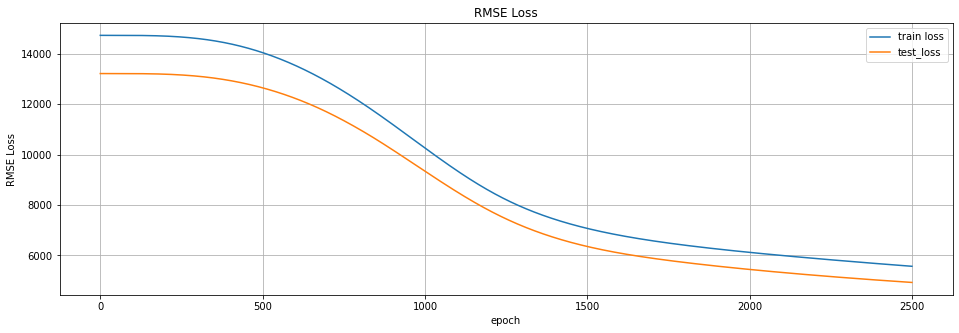

In [57]:
# Визуализация обучения нейросети
fig = plt.figure(figsize=(16, 5))
ax = sns.lineplot(np.arange(len(train_losses_final[:])), train_losses_final[:])
ax = sns.lineplot(np.arange(len(test_losses_final[:])), test_losses_final[:])
ax.set(xlabel='epoch', ylabel='RMSE Loss')
plt.legend(['train loss', 'test_loss'])
plt.title('RMSE Loss')
plt.grid()
ax.set_axisbelow(True)
plt.show()

In [58]:
rmse_first = min(test_losses_final)

In [59]:
print (f'Значение RMSE: {rmse_first}')

Значение RMSE: 4922.9560546875


In [60]:
def grafic(test_preds, target_test):
    preds = list(test_preds[0])
    fact = list(target_test.numpy())
    
    data = pd.DataFrame({'pred': preds, 'fact': fact})
    
    try:
        bars2 = data.iloc[:,0].str.replace(',','.').astype('int')
    except AttributeError:
        bars2 = data.iloc[:,0].astype('int')
        
    try:
        bars1 = data.iloc[:,1].str.replace(',','.').astype('int')
    except AttributeError:
        bars1 = data.iloc[:,1].astype('int')  
        
    xticks = data.index # задаем ось Х
# зададим разную ширину для графиков, ведь один будет наложен на другой, оба столбца будут идти из одних точек.
    barWidth1 = 0.065
    barWidth2 = 0.032
    x_range = np.arange(len(bars1) / 8, step=0.125)

# отобразим столбцы на графике, задав им положение, ширину, значения, цвет, легенду и подписи к диаграммам:
    plt.bar(x_range, bars1, color='#dce6f2', width=barWidth1/2, edgecolor='#c3d5e8', label='План')
    plt.bar(x_range, bars2, color='#ffc001', width=barWidth2/2, edgecolor='#c3d5e8', label='Факт')
    for i, bar in enumerate(bars2):
        plt.text(i / 8 - 0.015, bar + 1, bar, fontsize=14)
# отобразим столбцы на графике, задав им положение, ширину, значения, цвет, легенду 
    plt.xticks(x_range, xticks)
    plt.tick_params(
        bottom=False,
        left=False,
        labelsize=15
                    )
    plt.rcParams['figure.figsize'] = [25, 7]
    plt.axhline(y=0, color='gray')
    plt.legend(frameon=False, loc='lower center', bbox_to_anchor=(0.25, -0.3, 0.5, 0.5), prop={'size':20})
    plt.box(False)
    plt.savefig('plt', bbox_inches = "tight")
    plt.show()

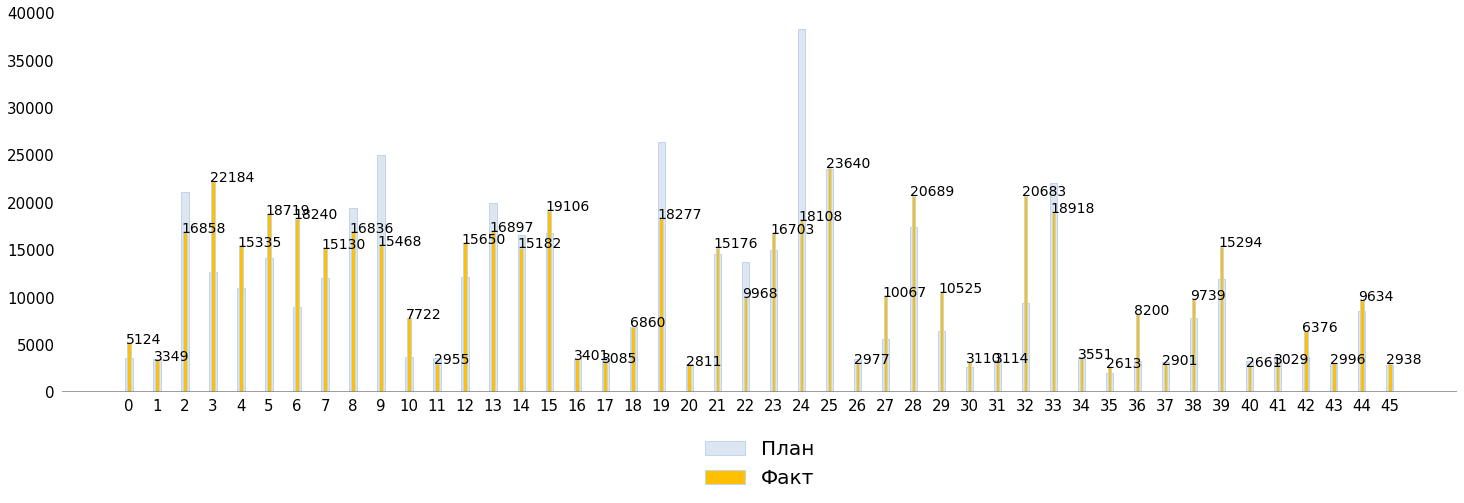

In [75]:
grafic(test_preds, target_test)

## Улучшение нейронной сети

Попробуем улучшить нашу сеть, добавив dropout. Воспользуемся библиотекой scorch (он поможет избежать подбора параметров на тестовых данных):

In [62]:
class Model_improve(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons, 
                 dropout_1, dropout_2, activation):
        super(Model_improve, self).__init__()

        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.dp1 = nn.Dropout(p=dropout_1)
        self.act1 = activation

        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.dp2 = nn.Dropout(p=dropout_2)
        self.act2 = activation

        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)

    def forward(self, x):
        x = self.fc1(x)
        x = self.dp1(x)
        x = self.act1(x)

        x = self.fc2(x)
        x = self.dp2(x)
        x = self.act2(x)

        x = self.fc3(x)

        return x

In [63]:
# Определяем rmse_scorer
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

rmse_scorer = make_scorer(rmse) 

Чтобы подобрать лучшие параметры, воспользуемся связкой scorch и RandomizedSearchCV. Согласно условию задачи исследования, архитектуру нейронной сети (количество слоёв, нейронов, вид функции активации) оставляем как в базовой модели, чтобы сравнить результат.

In [64]:
skorch_regressor = NeuralNetRegressor(module=Model_improve, 
                                      device='cpu',  
                                      verbose=3,
                                      batch_size=batch_size,
                                      optimizer=torch.optim.Adam, 
                                      max_epochs=2500, 
                                      lr=1e-3,
                                      criterion=nn.MSELoss,
                                      callbacks=[
                ('val_rmse', EpochScoring(scoring=rmse_scorer, lower_is_better=True, name='RMSE')),
                ('estoper', EarlyStopping(lower_is_better=True, monitor='RMSE')),
            ],
                                     ) 

In [65]:
# Зададим параметры
params = {
    'module__dropout_1': [0, 0.3],
    'module__dropout_2': [0, 0.3],
    'module__n_in_neurons': [features_train.shape[1]],
    'module__n_hidden_neurons_1': [14],
    'module__n_hidden_neurons_2': [35],
    'module__n_out_neurons': [1],
    'module__activation': [nn.ReLU()],
    'lr': [0.01, 0.001],
    'batch_size': range(10, 50, 10),
    'max_epochs': [100, 9000, 100]
}

Осуществим подбор параметров

In [66]:
grid = RandomizedSearchCV(skorch_regressor, params, cv=3, scoring="neg_root_mean_squared_error", verbose=3) 
grid.fit(features_train, target_train.reshape(-1,1)) 

Fitting 3 folds for each of 10 candidates, totalling 30 fits
  epoch        RMSE      train_loss      valid_loss     dur
-------  ----------  --------------  --------------  ------
      1  13152.7188  196067828.3333  172994016.0000  0.0280
      2  13152.6514  196065499.5000  172992262.4000  0.0230
      3  13152.5703  196063019.6667  172990118.4000  0.0260
      4  13152.4707  196059633.8333  172987507.2000  0.0190
      5  13152.3447  196056529.1667  172984172.8000  0.0143
Stopping since RMSE has not improved in the last 5 epochs.
[CV 1/3] END batch_size=10, lr=0.001, max_epochs=100, module__activation=ReLU(), module__dropout_1=0.3, module__dropout_2=0, module__n_hidden_neurons_1=14, module__n_hidden_neurons_2=35, module__n_in_neurons=14, module__n_out_neurons=1; total time=   0.2s
  epoch        RMSE      train_loss      valid_loss     dur
-------  ----------  --------------  --------------  ------
      1  16916.3086  205228462.3333  286161484.8000  0.0137
      2  16916.2520  205

RandomizedSearchCV(cv=3,
                   estimator=<class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=<class '__main__.Model_improve'>,
),
                   param_distributions={'batch_size': range(10, 50, 10),
                                        'lr': [0.01, 0.001],
                                        'max_epochs': [100, 9000, 100],
                                        'module__activation': [ReLU()],
                                        'module__dropout_1': [0, 0.3],
                                        'module__dropout_2': [0, 0.3],
                                        'module__n_hidden_neurons_1': [14],
                                        'module__n_hidden_neurons_2': [35],
                                        'module__n_in_neurons': [14],
                                        'module__n_out_neurons': [1]},
                   scoring='neg_root_mean_squared_error', verbose=3)

Посмотрим на наилучшие параметры и лучшую модель.

In [67]:
print(grid.best_score_, grid.best_params_, grid.best_estimator_)

-5163.845052083333 {'module__n_out_neurons': 1, 'module__n_in_neurons': 14, 'module__n_hidden_neurons_2': 35, 'module__n_hidden_neurons_1': 14, 'module__dropout_2': 0.3, 'module__dropout_1': 0, 'module__activation': ReLU(), 'max_epochs': 9000, 'lr': 0.01, 'batch_size': 10} <class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=Model_improve(
    (fc1): Linear(in_features=14, out_features=14, bias=True)
    (dp1): Dropout(p=0, inplace=False)
    (act1): ReLU()
    (fc2): Linear(in_features=14, out_features=35, bias=True)
    (dp2): Dropout(p=0.3, inplace=False)
    (act2): ReLU()
    (fc3): Linear(in_features=35, out_features=1, bias=True)
  ),
)


Протестируем модель, используя параметры лучшей модели и посмотрим какова метрика RMSE:

In [68]:
rmse_better = rmse(target_test, grid.predict(features_test))

In [69]:
display(f'RMSE улучшенной модели {rmse_better}')

'RMSE улучшенной модели 4450.28173828125'

Построим график фактических значений температур звезд и предсказанных:

In [70]:
new_test_preds = grid.best_estimator_.forward(features_test)

preds = np.asarray(list(itertools.chain.from_iterable(new_test_preds.numpy())))
fact = list(target_test.numpy())

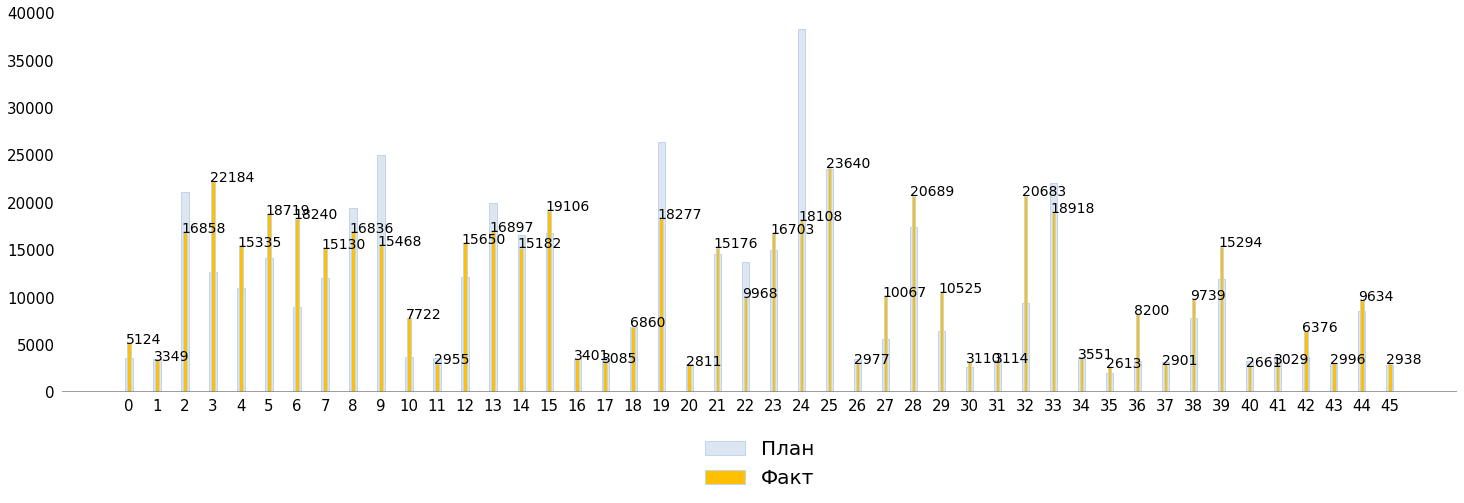

In [71]:
grafic(test_preds, target_test)

In [72]:
display(f'RMSE улучшилось на {int(rmse_first - rmse_better)}')

'RMSE улучшилось на 472'

Сравним две полученные модели:

In [78]:
data_comparison = pd.DataFrame([['Количество скрытых слоев', '2', '2'],
                                ['Количество нейронов на входе', '14','14'],
                                ['Количество нейронов 1слоя', '14', '14'],
                                ['Количество нейронов 2 слоя', '35', '35'],
                                ['Количество нейронов на выходе', '1', '1'],
                                ['Функция активации 1 слоя', 'ReLU', 'ReLU'],
                                ['Функция активации 2 слоя', 'ReLU', 'ReLU'],
                                ['dropout_1', '-', '0'],
                                ['dropout_2', '-', '0.3'],
                                ['Размер шага (lr)', '0.001', '0.01'],
                                ['Размер батча (batch_size)', '-', '10'],
                                ['Количество эпох', '2500', '9000'],
                                ['loss', 'MSELoss', 'MSELoss'],
                                ['optimizer', 'Adam', 'Adam'],
                                ['RMSE', rmse_first, rmse_better]],
                                columns=['Модель', 'Базовая', 'Улучшенная'])

In [79]:
data_comparison

,Модель,Базовая,Улучшенная
0,Количество скрытых слоев,2,2
1,Количество нейронов на входе,14,14
2,Количество нейронов 1слоя,14,14
3,Количество нейронов 2 слоя,35,35
4,Количество нейронов на выходе,1,1
5,Функция активации 1 слоя,ReLU,ReLU
6,Функция активации 2 слоя,ReLU,ReLU
7,dropout_1,-,0
8,dropout_2,-,0.3
9,Размер шага (lr),0.001,0.01


Были подобраны лучшие параметры для нейросети, используя связку scorch и RandomizedSearchCV. Согласно условию задачи исследования, архитектура нейронной сети (количество слоёв, нейронов, вид функции активации) осталась такой же, как в базовой модели. Полученный результат свели для наглядности в одну таблицу. Улучшение RMSE - 472.

## Выводы

Целью проекта была необходимость определить с помощью нейросети температуру на поверхности обнаруженных звёзд. В ходе исследования не были обнаружены пропущенные значения, дубликаты, но были очищены данные от излишних цветов. Выявленные выбросы решено было оставить из-за сильного уменьшения размера выборки в случае их удаления.

Использование dropout, подбора параметров в ходе улучшения сети, помогли добиться лучших результатов. Улучшенную модель можно считать более эффективной по сравнению с базовой. Метрика RMSE базовой модели составила 4923, улучшенной - 4450, что соответствует задаче исследования. Удалось добиться снижения RMSE на 472. На небольших температурах предсказание нейросети имеет самую малую разницу относительно реальных данных.